In [ ]:
#! pip install pyoso

In [42]:
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import os
import pandas as pd
from pyoso import Client

load_dotenv()
OSO_API_KEY = os.environ['OSO_API_KEY']
client = Client(api_key=OSO_API_KEY)

In [54]:
df_repositories = client.to_pandas("""
    SELECT DISTINCT
        artifact_id,
        artifact_namespace AS repo_owner,
        artifact_name AS repo_name,
        is_fork,
        star_count,
        fork_count,
        language,
        YEAR(created_at) AS created_year,
        YEAR(updated_at) AS last_updated_year
    FROM repositories_v0
    WHERE project_id IN (
        SELECT DISTINCT project_id FROM oso.projects_by_collection_v1
        WHERE collection_name LIKE '%ethereum%'
    )
""")
df_repositories.tail()

OsoHTTPError: 400 Client Error: Bad Request for url: https://www.opensource.observer/api/v1/sql - SYNTAX_ERROR: line 13:22: mismatched input 'IN'. Expecting: 'AND', 'EXCEPT', 'FETCH', 'GROUP', 'HAVING', 'INTERSECT', 'LIMIT', 'OFFSET', 'OR', 'ORDER', 'UNION', 'WINDOW', <EOF>

In [53]:
df_packages = client.to_pandas("""
    SELECT DISTINCT
        package_owner_artifact_id AS artifact_id,
        package_owner_artifact_namespace AS package_repo_owner,
        package_owner_artifact_name AS package_repo_name,
        package_artifact_source AS package_source,
        package_artifact_name AS package_name
    FROM package_owners_v0
    WHERE package_owner_project_id IN (
        SELECT DISTINCT project_id FROM oso.projects_by_collection_v1
        WHERE collection_name LIKE '%ethereum%'
    )
""")
df_packages.tail()

,artifact_id,package_repo_owner,package_repo_name,package_source,package_name
26719,K8JsakNPLU1Uad+6a+AH5x2rM3KnN7vrkQa5TL96+2Q=,open-telemetry,opentelemetry-js,NPM,@opentelemetry/instrumentation-grpc
26720,DQtex51zguo9p4IozXfR8piqidkkOb3+5KFEeT2ZEog=,jquery,download.jqueryui.com,NPM,download.jqueryui.com
26721,kuafwIaGQacwLnCK/ONOcVxk3pcdkTl4suVylvw50hg=,azure,azure-sdk-for-net,NUGET,microsoft.azure.management.locationbasedservices
26722,OZeZgwCFsmcZGAmkAPisFV6vFK5dA4mmXqBGf5kAiOA=,prettier-solidity,prettier-plugin-solidity,NPM,@134dd3v/prettier-plugin-solidity
26723,65MLcx/9thEYUXxFfN1x4v25pmuIaylQCp0BC+4H8/c=,textileio,go-threads,NPM,@textile/threads-client-grpc


In [9]:
df_dependencies = client.to_pandas("""
    WITH packages AS (
        SELECT DISTINCT
            package_owner_artifact_id AS artifact_id,
            package_owner_artifact_namespace AS artifact_namespace
        FROM package_owners_v0
        WHERE package_owner_project_id IN (
            SELECT DISTINCT project_id FROM oso.projects_by_collection_v1
            WHERE collection_name LIKE '%ethereum%'
        )
    ),
    repos AS (
        SELECT DISTINCT
            artifact_id,
            artifact_namespace
        FROM repositories_v0
        WHERE project_id IN (
            SELECT DISTINCT project_id FROM oso.projects_by_collection_v1
            WHERE collection_name LIKE '%ethereum%'
        )
    )
    SELECT DISTINCT
        cd.dependent_artifact_id,
        cd.dependency_artifact_id,
        cd.dependency_name,
        cd.dependency_source
    FROM int_code_dependencies AS cd
    JOIN packages ON cd.dependency_artifact_id = packages.artifact_id
    JOIN repos ON cd.dependent_artifact_id = repos.artifact_id
    WHERE packages.artifact_namespace != repos.artifact_namespace
""")
df_dependencies.tail()

In [32]:
df_merged = (
    df_dependencies
    .merge(df_repositories, left_on='dependent_artifact_id', right_on='artifact_id')
    .merge(df_packages, left_on='dependency_artifact_id', right_on='artifact_id')
)
cols = [
    'package_source',
    'package_name',
    'package_repo_owner',
    'package_repo_name', 
    'repo_owner',
    'repo_name',
    'star_count',
    'fork_count',
    'language',
    'created_year',
    'last_updated_year',
    'dependent_artifact_id',
    'dependency_artifact_id',
]
df_merged = df_merged[cols].drop_duplicates().reset_index(drop=True)
df_merged.to_parquet('data/ethereum_dependencies.parquet')
df_merged.tail()

,package_source,package_name,package_repo_owner,package_repo_name,repo_owner,repo_name,star_count,fork_count,language,created_year,last_updated_year,dependent_artifact_id,dependency_artifact_id
975872,NPM,@nomicfoundation/hardhat-viem,nomicfoundation,hardhat,tokamak-network,powerton-swapper,1,0,JavaScript,2021,2022,QfGe0RZX3TaeFoVPBKkCjZeb+iPVh840pDnRQUKCxQc=,/Mk3y4o7pUi5esk3VoLvZ5X++QZxfb74v4eq2fxM3BY=
975873,NPM,@nomicfoundation/hardhat-web3-v4,nomicfoundation,hardhat,tokamak-network,powerton-swapper,1,0,JavaScript,2021,2022,QfGe0RZX3TaeFoVPBKkCjZeb+iPVh840pDnRQUKCxQc=,/Mk3y4o7pUi5esk3VoLvZ5X++QZxfb74v4eq2fxM3BY=
975874,NPM,@nomicfoundation/hardhat-ethers,nomicfoundation,hardhat,tokamak-network,powerton-swapper,1,0,JavaScript,2021,2022,QfGe0RZX3TaeFoVPBKkCjZeb+iPVh840pDnRQUKCxQc=,/Mk3y4o7pUi5esk3VoLvZ5X++QZxfb74v4eq2fxM3BY=
975875,NPM,@nomicfoundation/edr-win32-ia32-msvc,nomicfoundation,hardhat,tokamak-network,powerton-swapper,1,0,JavaScript,2021,2022,QfGe0RZX3TaeFoVPBKkCjZeb+iPVh840pDnRQUKCxQc=,/Mk3y4o7pUi5esk3VoLvZ5X++QZxfb74v4eq2fxM3BY=
975876,NPM,ethereum-common,ethereumjs,common,mstable,mstable-contracts,305,79,TypeScript,2019,2025,tv/4GzzgT221VmgFBhTea8RBtUj5XvpzQ9GAWZV1f3o=,vkZVMhLasWIUr1B4mHijdQ+SqRJkvf8yGZ7/LF4iNIY=


In [33]:
df_merged[df_merged['package_name'] == 'solc']

,package_source,package_name,package_repo_owner,package_repo_name,repo_owner,repo_name,star_count,fork_count,language,created_year,last_updated_year,dependent_artifact_id,dependency_artifact_id
13272,NPM,solc,ethereum,solc-js,yflink,yflusd-frontend,0,1,TypeScript,2021,2021,r0knOFADQkWgpVMrNZ3YM3BWA5Gc53CCqQ/Lr0kYgI4=,LDJ1xTsHMgFqMEw+Li1ZAOB8/0R8ZguM93ufgshlhMo=
13275,NPM,solc,ethereum,solc-js,hifi-finance,hifi,105,16,TypeScript,2021,2024,S/m0SjbCBzwSIyR0YpvA8glXn0EhmXf+7z7Di/wIjpA=,LDJ1xTsHMgFqMEw+Li1ZAOB8/0R8ZguM93ufgshlhMo=
13278,NPM,solc,ethereum,solc-js,mahadao,liquidity-contracts,0,0,Solidity,2023,2023,Wyr1yxyXJL3SmKILGcmvj2/jROST2UqY/897SicjXWg=,LDJ1xTsHMgFqMEw+Li1ZAOB8/0R8ZguM93ufgshlhMo=
13281,NPM,solc,ethereum,solc-js,syncswap,testnet-contracts,3,4,Solidity,2022,2023,BiakCLubXzosXFr92HkZ8+tpQ6RzpIe14wj9ImI7cGA=,LDJ1xTsHMgFqMEw+Li1ZAOB8/0R8ZguM93ufgshlhMo=
19365,NPM,solc,ethereum,solc-js,tablelandnetwork,tutorial-two-tables-nft-polygon,2,0,JavaScript,2022,2023,idcFhNBBF45v6miCGLKMqd1cvorU6o7v7mAYTQ0PGe0=,LDJ1xTsHMgFqMEw+Li1ZAOB8/0R8ZguM93ufgshlhMo=
...,...,...,...,...,...,...,...,...,...,...,...,...,...
975720,NPM,solc,ethereum,solc-js,singnet,faucet-contracts,0,2,Solidity,2023,2025,DlGulXeLvMZK45yg5rIpMVH6q7eIw4eHWkEKOKUsAFo=,LDJ1xTsHMgFqMEw+Li1ZAOB8/0R8ZguM93ufgshlhMo=
975723,NPM,solc,ethereum,solc-js,vetherasset,vether-burn-contracts,0,2,Solidity,2020,2020,Zr3Wec/6Lx8VnMn1o6+OfQoL6oX4AC81GF7uEVoZSiE=,LDJ1xTsHMgFqMEw+Li1ZAOB8/0R8ZguM93ufgshlhMo=
975726,NPM,solc,ethereum,solc-js,enjin,claims-substrate,3,4,JavaScript,2021,2025,wLTiQp2i7/Em4uAmMaGBuN23rW2VOEAHPjsORZ/9U2M=,LDJ1xTsHMgFqMEw+Li1ZAOB8/0R8ZguM93ufgshlhMo=
975729,NPM,solc,ethereum,solc-js,transmute-industries,dapp,38,46,JavaScript,2017,2024,OEX/zcHpVlJJt0PukW4InoPbBu9C89PTMnUSm8J2ccs=,LDJ1xTsHMgFqMEw+Li1ZAOB8/0R8ZguM93ufgshlhMo=


<Axes: xlabel='last_updated_year'>

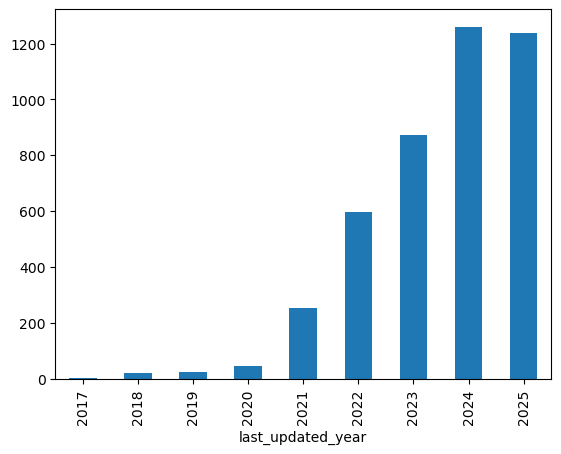

In [36]:
df_merged[df_merged['package_name'] == 'solc'].groupby('last_updated_year')['dependent_artifact_id'].nunique().plot(kind='bar')

In [24]:
df_stats = (
    df
    .groupby('package_repo_owner', as_index=False)
    .agg({'repo_owner': 'nunique', 'star_count': 'sum', 'package_name': lambda x: sorted(x.unique())})
    .rename(columns={
        'package_repo_owner': 'project',
        'repo_owner': 'dependent_projects',
        'star_count': 'dependent_stars',
        'package_name': 'package_list'
    })
    .sort_values(by=['dependent_projects', 'dependent_stars'], ascending=False)
)
df_stats.head(20)

,project,dependent_projects,dependent_stars,package_list
57,ethers-io,916,20902569,"[@ethers-ancillary/bsc, @ethersproject-aion/ab..."
56,ethereumjs,897,16421041,"[@embarklabs/ethereumjs-wallet, @ethereumjs/bl..."
53,ethereum,895,1555906,"[@ethereum-sourcify/bytecode-utils, @ethereum-..."
109,openzeppelin,781,1235524,"[@anthonymartin/solidity-docgen, @openzeppelin..."
103,nomicfoundation,700,3115039,"[@nomicfoundation/edr, @nomicfoundation/edr-da..."
52,ensdomains,590,322472,"[@ensdomains/address-encoder, @ensdomains/cont..."
168,wevm,419,1151335,"[@taped/prool, @wagmi/cli, @wagmi/connectors, ..."
69,graphprotocol,340,50546,"[@graphprotocol/client-add-source-name, @graph..."
37,coinbase,338,115951,"[@coinbase/cbpay-js, @coinbase/cdp-agentkit-co..."
171,zksync-sdk,255,38165,"[zksync-ethers, zksync-web3]"


In [48]:
df_contributors_all = client.to_pandas("""
    WITH repos AS (
        SELECT DISTINCT artifact_id
        FROM repositories_v0
        WHERE project_id IN (
            SELECT DISTINCT project_id 
            FROM projects_by_collection_v1
            WHERE collection_name LIKE '%ethereum%'
        )
    ),
    commit_events AS (
        SELECT
            bucket_month,
            from_artifact_id AS user_id,
            SUM(amount) AS commit_count
        FROM int_events_monthly_to_project__github
        WHERE
            event_type = 'COMMIT_CODE'
            AND to_artifact_id IN (SELECT artifact_id FROM repos)
        GROUP BY bucket_month, from_artifact_id
    ),
    user_stats AS (
        SELECT
            user_id,
            MIN(bucket_month) AS first_commit,
            MAX(bucket_month) AS last_commit            
        FROM commit_events
        GROUP BY user_id
    )
    SELECT
        DATE_FORMAT(commit_events.bucket_month, '%Y-%m-%d') AS bucket_month,
        commit_events.user_id,
        commit_events.commit_count,
        CASE
            WHEN commit_events.bucket_month = user_stats.first_commit THEN 'first_contribution'
            WHEN commit_events.bucket_month = user_stats.last_commit THEN 'last_contribution'
            ELSE 'regular_contribution'
        END AS label
    FROM commit_events
    JOIN user_stats
        ON commit_events.user_id = user_stats.user_id
""")

df_contributors_all

,bucket_month,user_id,commit_count,label
0,2023-12-01,zWcImtpPhrPUItHmRGPVd16qM5wEzKMkJHS0DmHEYGQ=,2,regular_contribution
1,2023-12-01,qu7cVDtHJpHPR76WK03B1nw6gDFUhFrnGKxlPW1LAQs=,2,regular_contribution
2,2023-12-01,ihuLgT6mL/P//34Y0CTVJ1MKBLK0Bz4QKArRsbSa4cQ=,5,regular_contribution
3,2023-12-01,KLm/rCtvj8lxX3ekOA1wCY+LpIPLAgn8Z/F8toM94T8=,134,regular_contribution
4,2023-12-01,TU/5juGWjdVSGgcswYAlo5IQUwCtU85QwcNXOQSXLuk=,51,regular_contribution
...,...,...,...,...
129503,2024-11-01,lqpg6It7ac8oDu5FUt/Wh7HhYS7D831hSoJka+VmLQI=,21,regular_contribution
129504,2024-11-01,vKRPG/R8jChmsGHoY4v+k/jq1lPaV25hlCmTI9K5Tp4=,36,regular_contribution
129505,2024-11-01,zJ/OQzVy9zgT7fMr3fnjfz3tbQzqliT29aUgncXL3v8=,187,regular_contribution
129506,2024-11-01,Mw7ru8g7JemGpRhtbVoFUlq8/MG7ibFHCJXUQPKMVGU=,6,regular_contribution


<Axes: xlabel='bucket_month'>

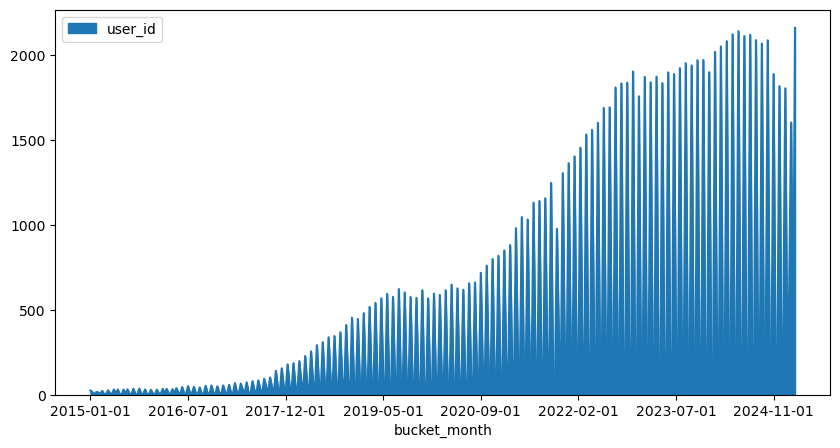

In [52]:
fig, ax = plt.subplots(figsize=(10,5))
df_contributors_all.groupby([
    'bucket_month',
    'label'
], as_index=False)['user_id'].nunique().plot(x='bucket_month', y='user_id', kind='area', ax=ax)

In [39]:
df_contributors = client.to_pandas("""
    WITH repos AS (
        SELECT DISTINCT artifact_id
        FROM repositories_v0
        WHERE project_id IN (
            SELECT DISTINCT project_id FROM oso.projects_by_collection_v1
            WHERE collection_name LIKE '%ethereum%'
        )
    )
    select
        bucket_month,
        approx_distinct(from_artifact_id) as num_contributors
    from oso.int_events_monthly_to_project__github
    where
        event_type = 'COMMIT_CODE'
        and to_artifact_id IN (SELECT artifact_id FROM repos)
    group by bucket_month
    order by bucket_month
""")
df_contributors

,bucket_month,num_contributors
0,2015-01-01 00:00:00.000,24
1,2015-02-01 00:00:00.000,31
2,2015-03-01 00:00:00.000,36
3,2015-04-01 00:00:00.000,30
4,2015-05-01 00:00:00.000,40
...,...,...
118,2024-11-01 00:00:00.000,2252
119,2024-12-01 00:00:00.000,2229
120,2025-01-01 00:00:00.000,2409
121,2025-02-01 00:00:00.000,2323


<Axes: xlabel='bucket_month'>

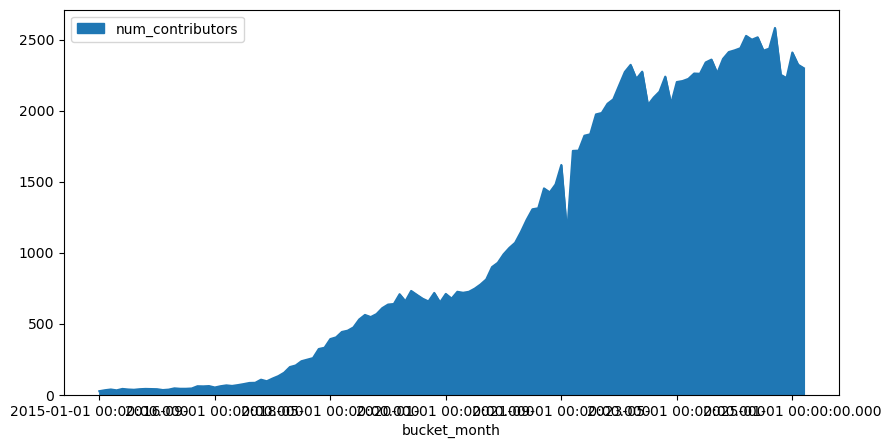

In [43]:
fig, ax = plt.subplots(figsize=(10,5))
df_contributors.plot(x='bucket_month', y='num_contributors', kind='area', ax=ax)